# Chargement des modules 

In [1]:
# Les classiques
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

# visualisation dynamique
import plotly.express as px

# Modules pour les séries chronologiques
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX


from pmdarima.arima import auto_arima

# Chargement des données et visualisation

In [27]:

path = "/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Série chronologiques_Proïa/projet_electricité/Dataset_CB.csv"

EDF = pd.read_csv(path)

EDF.columns = ["DATE","CONSO"]

EDF.DATE = pd.to_datetime(EDF.DATE,format='%d/%m/%y %H:%M')

print("shape = ",EDF.shape)

EDF


shape =  (744, 2)


,DATE,CONSO
0,2023-08-01 00:00:00,522.646044
1,2023-08-01 01:00:00,142.889213
2,2023-08-01 02:00:00,497.052422
3,2023-08-01 03:00:00,110.082063
4,2023-08-01 04:00:00,333.036926
...,...,...
739,2023-08-31 19:00:00,1216.824530
740,2023-08-31 20:00:00,1867.397655
741,2023-08-31 21:00:00,6456.590007
742,2023-08-31 22:00:00,915.149345


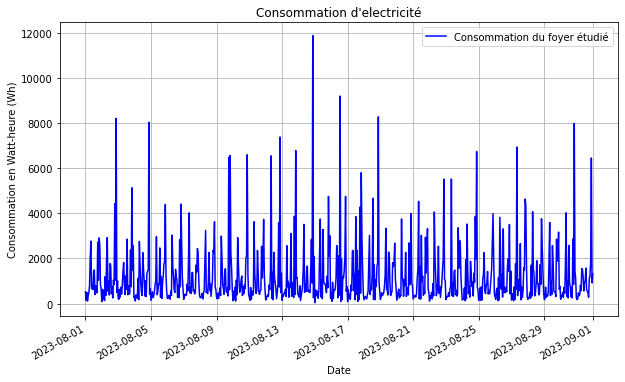

In [28]:
# Tracez les données avec une ligne solide bleue et ajoutez des marqueurs

plt.figure(figsize=(10,6))
plt.plot(EDF.DATE.values, EDF.CONSO.values, linestyle='-', color='b', label='Consommation du foyer étudié')
plt.legend()
plt.title("Consommation d'electricité")
plt.xlabel("Date")
plt.ylabel("Consommation en Watt-heure (Wh)")
plt.gcf().autofmt_xdate() # Personnalisez les axes pour afficher les dates de manière plus lisible
plt.grid(True)
plt.show()

# Passage au log pour atténuer les pics  

In [29]:
EDF['LOGCONSO'] = np.log(EDF.CONSO)
EDF.head()

,DATE,CONSO,LOGCONSO
0,2023-08-01 00:00:00,522.646044,6.258904
1,2023-08-01 01:00:00,142.889213,4.962070
2,2023-08-01 02:00:00,497.052422,6.208695
3,2023-08-01 03:00:00,110.082063,4.701226
4,2023-08-01 04:00:00,333.036926,5.808253


In [30]:
# Créez un graphique interactif avec Plotly Express
fig = px.line(EDF, x='DATE', y='LOGCONSO', labels={'DATE': 'Date', 'LOGCONSO': 'Log consommation'})
fig.update_layout(title="Log-consommation d'énergie du foyer")

# Affichez le graphique interactif
fig.show()

Au vu de ce graphique, la stationnarité ne semble pas remis en cause, nous allons appuyer cette hypothèse grâce aux tests ADF et KPSS

In [31]:
# On va différentier une fois pour regarder les incréments à une heure près
EDF["diff1"] = EDF.LOGCONSO.diff(1) 

# Créez un graphique interactif avec Plotly Express
fig = px.line(EDF, x='DATE', y="diff1", labels={'DATE': 'Date', 'diff1': ''})
fig.update_layout(title="Différentiation de la Log-consommation d'énergie du foyer")
fig.show()

Au vu de ce graphique, la stationnarité ne semble pas trop remis en cause, nous allons appuyer cette hypothèse grâce aux tests ADF et KPSS

In [32]:
# On va différentier une fois pour regarder les incréments à 24 heures près
EDF["diff24"] = EDF.LOGCONSO.diff(24) 
fig = px.line(EDF, x='DATE', y="diff24", labels={'DATE': 'Date', 'diff24': ''})
fig.update_layout(title="Différentiation saisonnière de la Log-consommation d'énergie du foyer")
fig.show()

Au vu de ce graphique, la stationnarité au niveau de la variance du processus semble remis en cause, nous allons voir si les tests ADF et KPSS sont réceptifs à ce genre de non stationnarité. 

# Test de Stationnarité 

## Sans différentier

In [33]:
# Testons la non-stationnarité 
TestA = adfuller(EDF.LOGCONSO) # Test ADF rejeté
print("ADF p-val : ", TestA[1])

# Testons la stationnarité 
TestK = kpss(EDF.LOGCONSO) # Test KPSS non rejeté 
print("KPSS p-val : ", TestK[1])# Test non rejeté 

ADF p-val :  0.0
KPSS p-val :  0.1


/tmp/ipykernel_19851/2687361320.py:6: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Il semblerait que les données suivantes soient stationnaires, nous pouvons ainsi essayer de mettre un modèle mathématiques de type (AR, MA, ARIMA, SARIMA) que nous avons étudiés durant ce semestre. 

## Avec différentiation 

In [34]:
# Testons la non-stationnarité 
TestA = adfuller(EDF.diff1.dropna()) # Test ADF rejeté
print("ADF p-val : ", TestA[1])

# Testons la stationnarité 
TestK = kpss(EDF.diff1.dropna()) # Test KPSS non rejeté 
print("KPSS p-val : ", TestK[1])# Test non rejeté 

ADF p-val :  6.256435132748781e-22
KPSS p-val :  0.1


/tmp/ipykernel_19851/1720817923.py:6: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Il semblerait que les données suivantes soient stationnaires, nous pouvons ainsi essayer de mettre un modèle mathématiques de type (AR, MA, ARIMA, SARIMA) que nous avons étudiés durant ce semestre. 

## Avec différentiation saisonnière s=24

In [35]:
# Testons la non-stationnarité 
TestA = adfuller(EDF.diff24.dropna()) # Test ADF rejeté au seuil de 5%
print("ADF p-val : ", TestA[1])

# Testons la stationnarité 
TestK = kpss(EDF.diff24.dropna()) # Test KPSS non rejeté 
print("KPSS p-val : ", TestK[1])# Test non rejeté 

ADF p-val :  0.00022114078230846984
KPSS p-val :  0.1


/tmp/ipykernel_19851/2374260748.py:6: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Il semblerait que les données suivantes soient stationnaires au vu des tests, cependant nous avons observé une non stationnarité flagrante en variance du processus. Ceci illustre bien la méfiance que nous devons avoir face aux résultats des test ADF et KPSS.

# Étude des corrélations

## sans différentiation

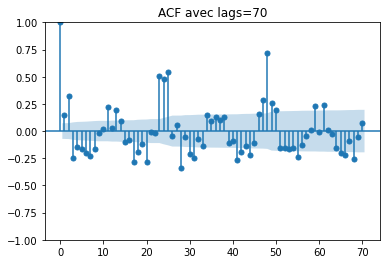

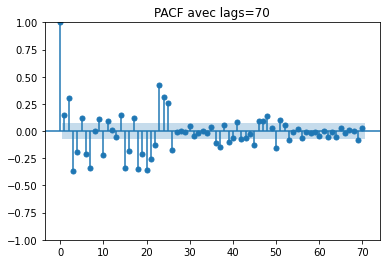

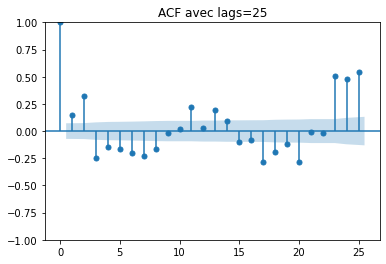

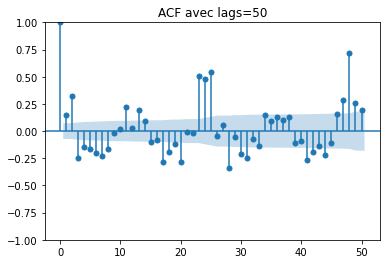

In [36]:
ACF = plot_acf(EDF.LOGCONSO, lags=70, alpha=0.05,title="ACF avec lags=70") 
PACF = plot_pacf(EDF.LOGCONSO, lags=70, alpha=0.05,title="PACF avec lags=70")

ACF = plot_acf(EDF.LOGCONSO, lags=25, alpha=0.05,title="ACF avec lags=25") 

ACF = plot_acf(EDF.LOGCONSO, lags=50, alpha=0.05,title="ACF avec lags=50")


On remarque qu'il y a un regain d'amplitude dans l'ACF au niveau de la valeur h=24 et h= 48, une saisonalité de 24 semble être visible. De plus cette information semble cohérente avec les données car chaque journée contient 24 heures donc 24 observations par jours. L'ACF et la PACF ne nous donne pas plus d'informations quand aux ordres (p,d,q) et (P,D,Q) pour un modèle de type SARIMA


## Avec différentiation

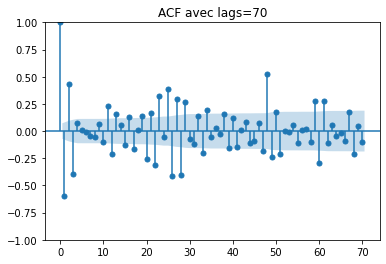

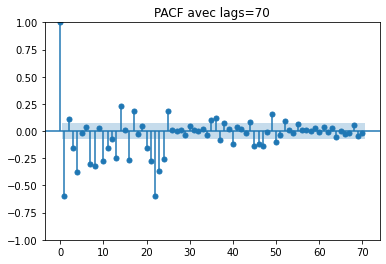

In [38]:
ACF = plot_acf(EDF.diff1.dropna(), lags=70, alpha=0.05,title="ACF avec lags=70") 
PACF = plot_pacf(EDF.diff1.dropna(), lags=70, alpha=0.05,title="PACF avec lags=70")


# Recherche avec la fonction Auto_arima

## Un modèle sans différentiation

In [ ]:
auto_arima(EDF.LOGCONSO, start_p=0, start_q=0, seasonal=True, start_P=0, start_Q=0, m=24, d=0, D=0, with_intercept=True, stepwise=True, trace=True)
#force D=d=0 # trace=True pour afficher # stepwise=True passe d'un modèle à l'autre 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45442D+01    |proj g|=  5.82232D+01

At iterate    5    f=  1.31438D+00    |proj g|=  6.99132D-01

At iterate   10    f=  8.38360D-01    |proj g|=  3.33551D-01

At iterate   15    f=  7.61134D-01    |proj g|=  1.60888D-01

At iterate   20    f=  7.51677D-01    |proj g|=  1.96873D-01

At iterate   25    f=  7.30548D-01    |proj g|=  2.91009D-01

At iterate   30    f=  7.25303D-01    |proj g|=  9.89038D-01

At iterate   35    f=  7.16244D-01    |proj g|=  2.17401D-01

At iterate   40    f=  7.10683D-01    |proj g|=  3.04074D-01

At iterate   45    f=  6.50722D-01    |proj g|=  3.59922D-01


/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  5.50591D-01    |proj g|=  1.50838D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     62      1     0     0   1.508D+00   5.506D-01
  F =  0.55059104815259596     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                      
Dep. Variable:                           LOGCONSO   No. Observations:                  744
Model:             SARIMAX(5, 0, 0)x(2, 0, 0, 24)   Log Likelihood                -409.640
Date:                            Fri, 15 Dec 2023   AIC                            837.2

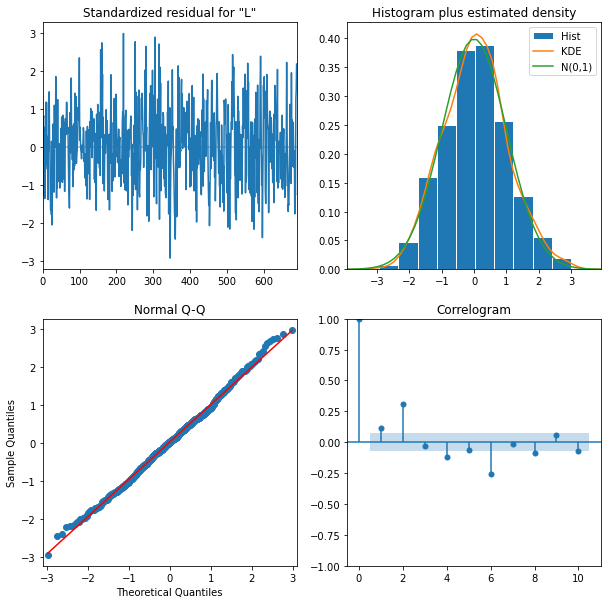

In [42]:
Mod1 = SARIMAX(EDF.LOGCONSO, order=(5, 0, 0), seasonal_order=(2, 0, 0, 24),trend='c', enforce_stationarity=False, enforce_invertibility=False)
Mod1 = Mod1.fit()
print(Mod1.summary())
plot1 = Mod1.plot_diagnostics(figsize=(10,10),,lags=70)

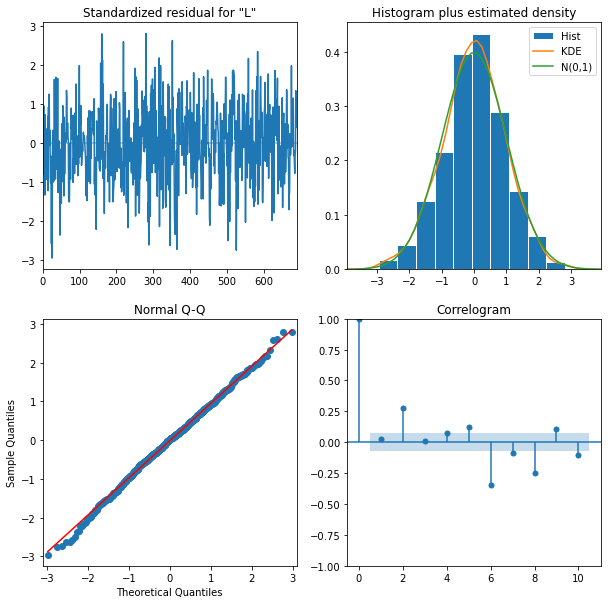

## Un modèle avec différentiation

In [ ]:
auto_arima(EDF.diff1.dropna(), start_p=0, start_q=0, seasonal=True, start_P=0, start_Q=0, m=24, d=1, D=0, with_intercept=True, stepwise=True, trace=True)
#force d=0 # trace=True pour afficher # stepwise=True passe d'un modèle à l'autre 

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22949D+00    |proj g|=  6.90050D-01

At iterate    5    f=  8.19794D-01    |proj g|=  3.80310D-01

At iterate   10    f=  6.79402D-01    |proj g|=  8.18275D-01

At iterate   15    f=  5.96336D-01    |proj g|=  4.48611D-01

At iterate   20    f=  5.83522D-01    |proj g|=  8.76273D-01

At iterate   25    f=  5.51679D-01    |proj g|=  4.05646D-01

At iterate   30    f=  5.48463D-01    |proj g|=  2.68769D-01

At iterate   35    f=  5.42887D-01    |proj g|=  1.10406D-01

At iterate   40    f=  5.38188D-01    |proj g|=  2.70809D-01

At iterate   45    f=  5.31086D-01    |proj g|=  1.61314D-01


/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  5.30822D-01    |proj g|=  8.31154D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     66      1     0     0   8.312D-02   5.308D-01
  F =  0.53082231660389922     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                                diff1   No. Observations:                  743
Model:             SARIMAX(5, 1, 0)x(2, 0, [1], 24)   Log Likelihood                -394.401
Date:                              Fri, 15 Dec 2023   AIC                         

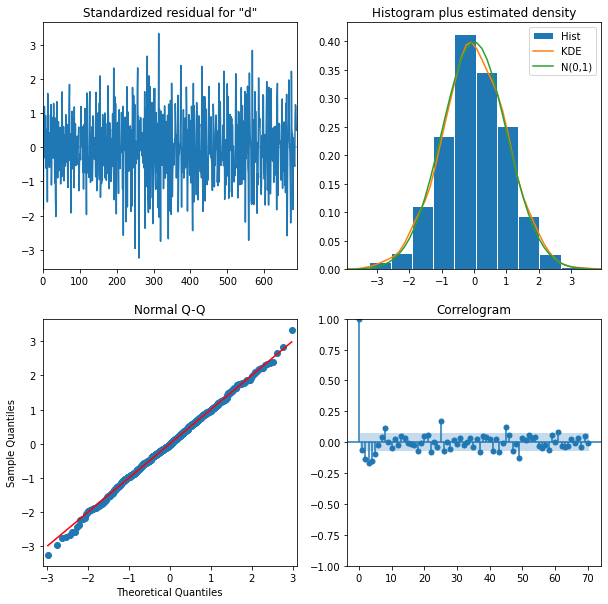

In [44]:
Mod2 = SARIMAX(EDF.diff1.dropna(), order=(5, 1, 0), seasonal_order=(2, 0, 1, 24),trend='c', enforce_stationarity=False, enforce_invertibility=False)
Mod2 = Mod2.fit()
print(Mod2.summary())
plot2 = Mod2.plot_diagnostics(figsize=(10,10),lags=70)

# Seconde approche avec un desompose clasique de EDF.LONGCONSO

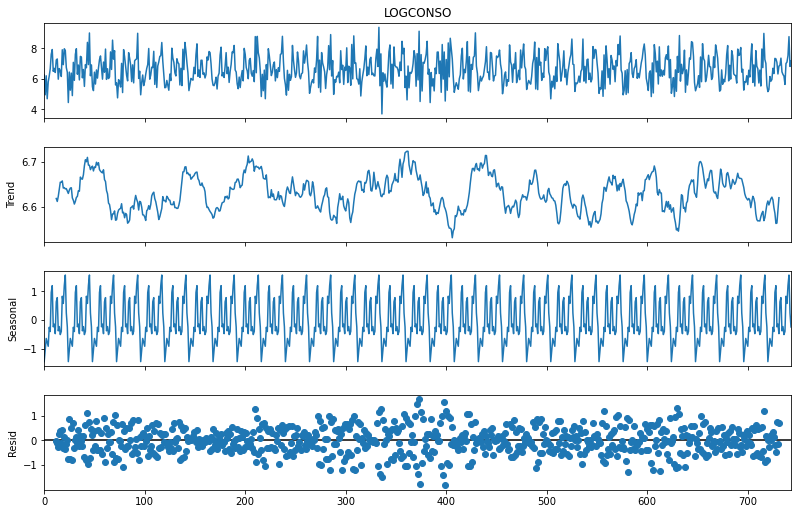

In [62]:


Decomp = sm.tsa.seasonal_decompose(EDF.LOGCONSO, model='additive', period=24)  # Modèle additif

plotd1 = Decomp.plot()
plt.gcf().set_size_inches(12, 8)  # Redimensionner la figure
plt.show() 

In [63]:
Mean = EDF.LOGCONSO.mean()
EDF["LC_res"] = EDF.LOGCONSO -Decomp.seasonal - Mean

fig = px.line(EDF, x='DATE', y="LC_res", labels={'DATE': 'Date', 'LC_res': 'Résidu '})
fig.update_layout(title="Log-consommation d'énergie du foyer centrée et sans composante périodique")
fig.show()


Au vu de ce graphique, la stationnarité au niveau de la variance du processus semble remis en cause. 

## Une approche avec un modèle ARCH/GARCH sur les données précédentes

# Troisième approche utilisation de FB-Prophet EDF.LONGCONSO

In [71]:
EDF_Fb = EDF[["DATE","LOGCONSO"]]


EDF_Fb = EDF_Fb.reset_index().rename(columns ={'DATE':"ds",'LOGCONSO':"y"} )

from prophet import Prophet

ModFB = Prophet(interval_width=0.95)
ModFB.fit(EDF_Fb)


15:21:26 - cmdstanpy - INFO - Chain [1] start processing
15:21:26 - cmdstanpy - INFO - Chain [1] done processing


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

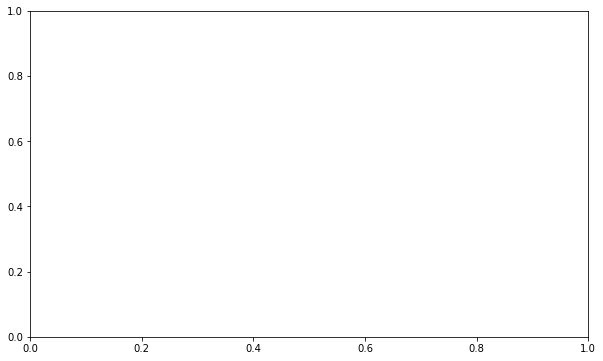

In [77]:
# On propose une périodicité mensuelle
# On veut une prédiction sur un mois
FutureDates = ModFB.make_future_dataframe(periods=3*24*30, freq='H')
Pred = ModFB.predict(df=FutureDates)


Fig = ModFB.plot(np.array(Pred))